# MT Mount Characterization

From Craig Lage's notebook collection

In [1]:
import sys, time, os, asyncio, glob
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from astropy.time import Time, TimeDelta

from lsst_efd_client import EfdClient
from lsst.sitcom.vandv.efd import create_efd_client

In [2]:
client = create_efd_client()

In [3]:
# Now let's try to expand it to the whole run
start = Time("2023-01-26T06:51:00", scale='utc')
end = Time("2023-01-26T09:50:00", scale='utc')

az = await client.select_time_series('lsst.sal.MTMount.azimuth', \
                                            ['actualPosition', 'timestamp'],  start, end)
el = await client.select_time_series('lsst.sal.MTMount.elevation', \
                                            ['actualPosition', 'timestamp'],  start, end)    

az_track = await client.select_time_series('lsst.sal.MTMount.command_trackTarget', \
                                            ['azimuth', 'taiTime'],  start, end)
el_track = await client.select_time_series('lsst.sal.MTMount.command_trackTarget', \
                                            ['elevation', 'taiTime'],  start, end)   
print(len(az_track), len(el_track))

204221 204221


<AxesSubplot: >

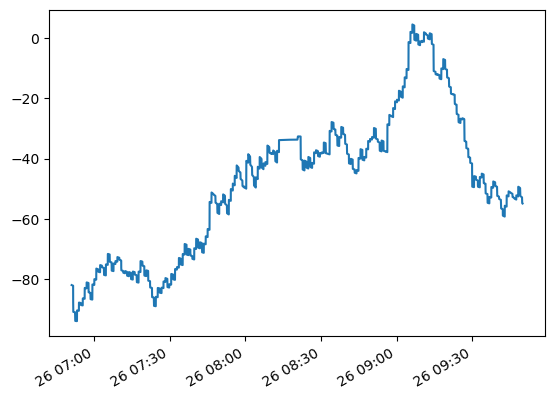

In [4]:
az['actualPosition'].plot()

In [5]:
azPos = await client.select_time_series('lsst.sal.MTMount.logevent_azimuthInPosition', \
                                            ['inPosition', 'private_kafkaStamp'],  start, end)
azPos = azPos[azPos['inPosition']] # Select only the True values
elPos = await client.select_time_series('lsst.sal.MTMount.logevent_elevationInPosition', \
                                            ['inPosition', 'private_kafkaStamp'],  start, end)
elPos = elPos[elPos['inPosition']] # Select only the True values
print(len(azPos), len(elPos))

225 225


In [6]:
# Find all of the time stamps

# Start with start_slew times

azs = az_track.values[:,0]
els = el_track.values[:,0]
times = az_track.values[:,1]
start_slew_times_1 = []
slew_dist_1 = []
slew_times_1 = []
for i in range(1,len(az_track)):
    az_shift = abs(azs[i] - azs[i-1])
    el_shift = abs(els[i] - els[i-1])
    if (az_shift > 0.1) or (el_shift > 0.1):
        start_slew_times_1.append(times[i])
        az_shift_mod = az_shift * np.cos(els[i]*np.pi/180.0)
        shift = np.sqrt(el_shift*el_shift + az_shift_mod*az_shift_mod)
        slew_dist_1.append(shift)
print(len(start_slew_times_1))

# Now in position timestamps

inPos_1 = []
azPosValues = azPos.values[:,1]
elPosValues = elPos.values[:,1]

for i in range(len(azPos)):
    if azPosValues[i] > elPosValues[i]:
        inPos_1.append(azPosValues[i])
    else:
        inPos_1.append(elPosValues[i])

print(len(inPos_1))

# Now pair them up

pairMin = 1.0
pairMax = 6.0

start_slew_times = []
slew_dist = []
slew_times = []
inPos = []

for i in range(len(start_slew_times_1)):
    for j in range(len(inPos_1)):
        deltaT = inPos_1[j] - start_slew_times_1[i] 
        if deltaT > pairMin and deltaT < pairMax:
            inPos.append(inPos_1[j])
            start_slew_times.append(start_slew_times_1[i])
            slew_times.append(deltaT)
            slew_dist.append(slew_dist_1[i])
        
print(len(inPos), len(start_slew_times), len(slew_times), len(slew_dist))

224
225
223 223 223 223


Text(0.5, 0, 'Slew distance (degrees)')

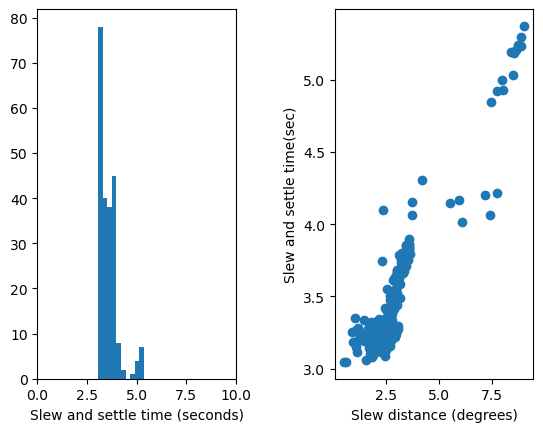

In [8]:
plt.subplots_adjust(wspace=0.5)
plt.subplot(1,2,1)
plt.hist(slew_times)
plt.xlabel("Slew and settle time (seconds)")
plt.xlim(0.0, 10.0)
plt.subplot(1,2,2)
plt.scatter(slew_dist, slew_times)
plt.ylabel("Slew and settle time(sec)")
plt.xlabel("Slew distance (degrees)")

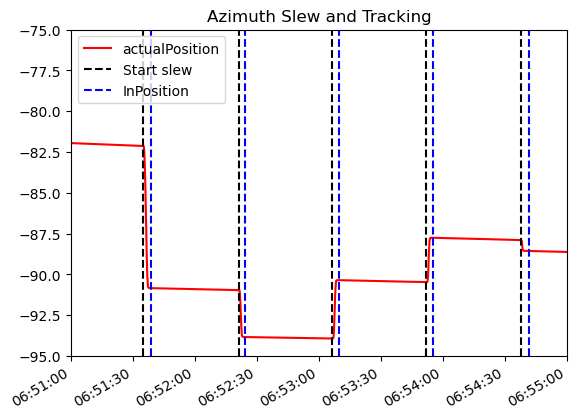

In [9]:
delta1 = 0
delta = 240
azPos_values = azPos.values[:,1]
plt.subplot(1,1,1)
plt.title("Azimuth Slew and Tracking")
ax1 = az['actualPosition'].plot(color='red')
for start_slew_time in start_slew_times:
    ss_time = Time(start_slew_time, format='unix_tai', scale='utc').isot  
    ax1.axvline(ss_time, color="black", linestyle="--")
for inP in inPos:
    ip_time = Time(inP, format='unix_tai', scale='utc').isot  
    ax1.axvline(ip_time, color="blue", linestyle="--")
ax1.set_xlim((start+TimeDelta(delta1, format='sec')).isot, (start+TimeDelta(delta, format='sec')).isot)
ax1.axvline(ss_time, color="black", linestyle="--", label="Start slew")
ax1.axvline(ip_time, color="blue", linestyle="--", label="InPosition")
ax1.set_ylim(-95, -75)
ax1.legend()


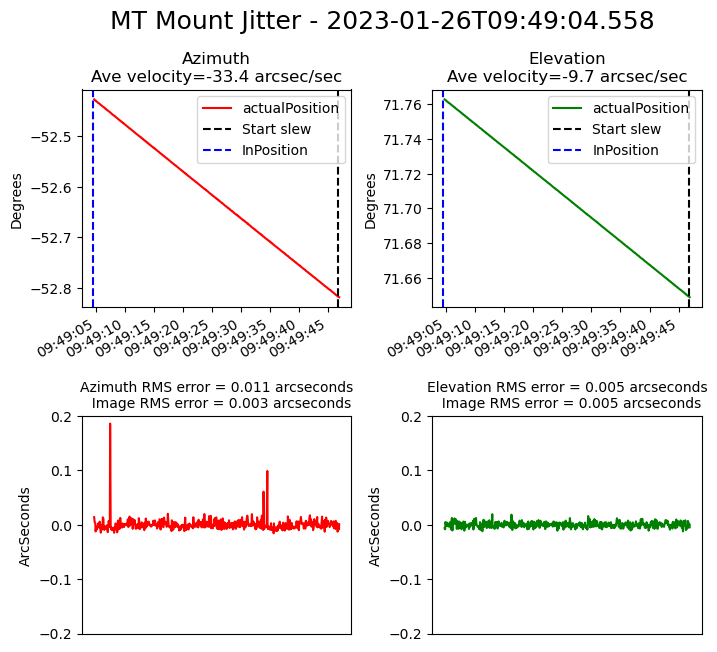

In [11]:
# Plotting the mount plots
azRmsVals = []
elRmsVals = []
imRmsVals = []
fig = plt.figure(figsize = (8,8))
for index in range(len(inPos) - 1):

    plotAz = az[(az['timestamp'] > inPos[index]) & (az['timestamp'] < start_slew_times[index+1])]
    plotEl = el[(el['timestamp'] > inPos[index]) & (el['timestamp'] < start_slew_times[index+1])]
    ss_time = Time(start_slew_times[index+1], format='unix_tai', scale='utc').isot
    ip_time = Time(inPos[index], format='unix_tai', scale='utc').isot


    # Calculate the tracking errors
    az_vals = np.array(plotAz.values[:,0])
    el_vals = np.array(plotEl.values[:,0])
    times_az = plotAz.values[:,1]
    times_el = plotEl.values[:,1]
    # The fits are much better if the time variable
    # is centered in the interval
    time_delta_az = times_az[int(len(plotAz.values) / 2)]
    time_delta_el = times_el[int(len(plotEl.values) / 2)]
    fit_times_az = [(times_az[i]-time_delta_az) for i in range(len(times_az))]
    fit_times_el = [(times_el[i]-time_delta_el) for i in range(len(times_el))]

    # Fit with a polynomial
    az_fit = np.polyfit(fit_times_az, az_vals, 4)
    el_fit = np.polyfit(fit_times_el, el_vals, 4)
    az_model = np.polyval(az_fit, fit_times_az)
    el_model = np.polyval(el_fit, fit_times_el)

    # Errors in arcseconds
    az_error = (az_vals - az_model) * 3600
    el_error = (el_vals - el_model) * 3600
    
    # Drive velocities
    az_vel = (az_model[-1] - az_model[0]) / (fit_times_az[-1] - fit_times_az[0]) * 3600.0
    el_vel = (el_model[-1] - el_model[0]) / (fit_times_el[-1] - fit_times_el[0]) * 3600.0
    
    # Calculate RMS
    az_rms = np.sqrt(np.mean(az_error * az_error))
    el_rms = np.sqrt(np.mean(el_error * el_error))
    azRmsVals.append(az_rms)
    elRmsVals.append(el_rms)
    # Calculate Image impact RMS
    # We are less sensitive to Az errors near the zenith
    image_az_rms = az_rms * np.cos(el_vals[0] * np.pi / 180.0)
    image_el_rms = el_rms
    imRmsVals.append(np.sqrt(image_az_rms*image_az_rms + image_el_rms*image_el_rms))

    fig.clear()
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.suptitle(f"MT Mount Jitter - {ip_time}", fontsize = 18)
    plt.subplot(2,2,1)
    ax1 = plotAz['actualPosition'].plot(legend=True, color='red')
    ax1.axvline(ss_time, color="black", linestyle="--", label="Start slew")
    ax1.axvline(ip_time, color="blue", linestyle="--", label="InPosition")
    ax1.set_title(f"Azimuth\nAve velocity={az_vel:.1f} arcsec/sec")
    ax1.set_ylabel("Degrees")
    ax1.legend()
    plt.subplot(2,2,2)
    ax3 = plotEl['actualPosition'].plot(legend=True, color='green')
    ax3.axvline(ss_time, color="black", linestyle="--", label="Start slew")
    ax3.axvline(ip_time, color="blue", linestyle="--", label="InPosition")
    ax3.set_title(f"Elevation\nAve velocity={el_vel:.1f} arcsec/sec")
    ax3.set_ylabel("Degrees")
    ax3.legend()
    plt.subplot(2,2,3)
    plt.plot(fit_times_az, az_error, color='red')
    plt.title(f"Azimuth RMS error = {az_rms:.3f} arcseconds\n"
              f"  Image RMS error = {image_az_rms:.3f} arcseconds", fontsize=10)
    plt.ylim(-0.2,0.2)
    plt.xticks([])
    plt.ylabel("ArcSeconds")
    plt.subplot(2,2,4)
    plt.plot(fit_times_el, el_error, color='green')
    plt.title(f"Elevation RMS error = {el_rms:.3f} arcseconds\n"
              f"  Image RMS error = {image_el_rms:.3f} arcseconds", fontsize=10)
    plt.ylim(-0.2,0.2)
    plt.xticks([])
    plt.ylabel("ArcSeconds")
    timestamp = ip_time.split('.')[0].replace('-','').replace(':','')


mount_data = {}
mount_data['start_slew_times'] = start_slew_times
mount_data['inPos'] = inPos
mount_data['slew_times'] = slew_times
mount_data['slew_dist'] = slew_dist
mount_data['azRmsVals'] = azRmsVals
mount_data['elRmsVals'] = elRmsVals
mount_data['imRmsVals'] = imRmsVals


Text(0.5, 0, 'RMS Jitter (arcseconds)')

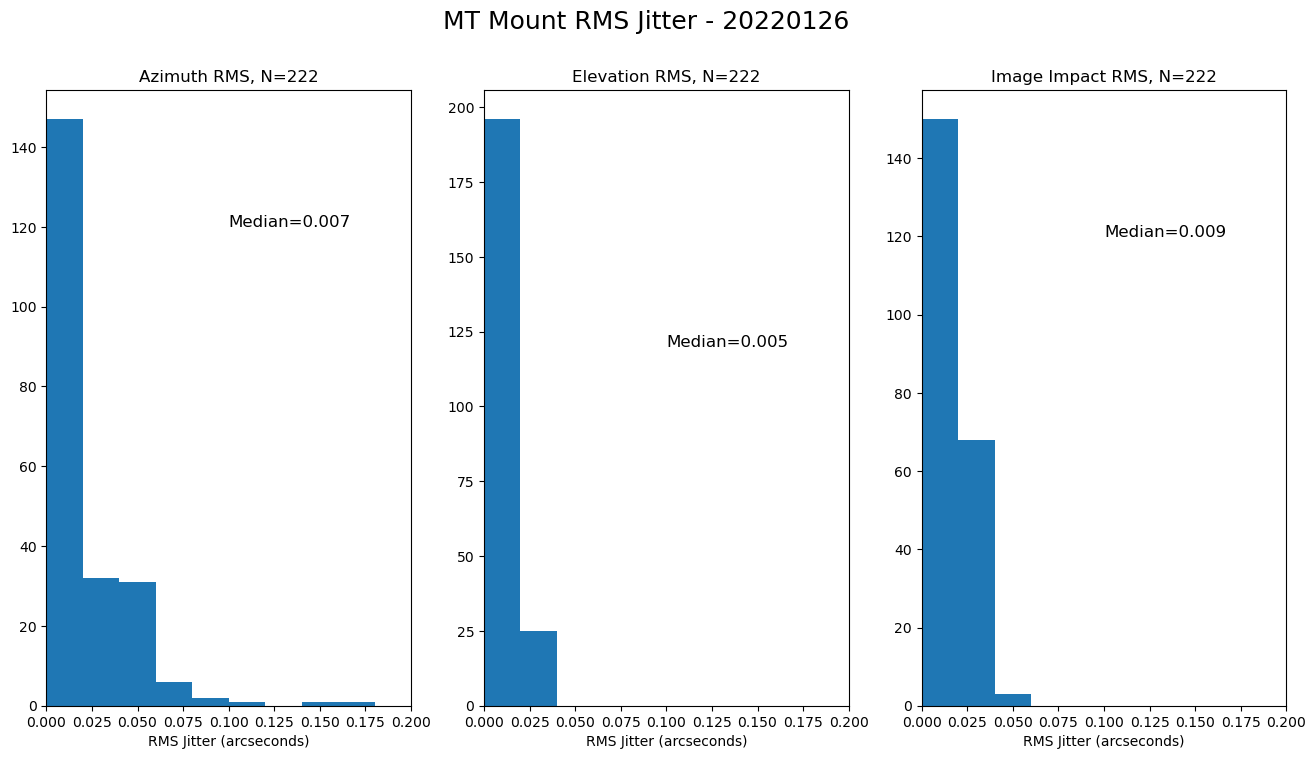

In [12]:
fig = plt.figure(figsize=(16,8))
plt.suptitle("MT Mount RMS Jitter - 20220126", fontsize = 18)
azRmsVals = mount_data['azRmsVals']
elRmsVals = mount_data['elRmsVals']
imRmsVals = mount_data['imRmsVals']
azMed = np.median(azRmsVals)
elMed = np.median(elRmsVals)
imMed = np.median(imRmsVals)
plt.subplots_adjust(wspace=0.2)
plt.subplot(1,3,1)
plt.title(f"Azimuth RMS, N={len(azRmsVals)}")
plt.hist(azRmsVals, range=(0,0.2))
plt.text(0.1,120, f"Median={azMed:.3f}", fontsize=12)
plt.xlim(0,0.2)
plt.xlabel("RMS Jitter (arcseconds)")
plt.subplot(1,3,2)
plt.title(f"Elevation RMS, N={len(azRmsVals)}")
plt.hist(elRmsVals, range=(0,0.2))
plt.text(0.1,120, f"Median={elMed:.3f}", fontsize=12)
plt.xlim(0,0.2)
plt.xlabel("RMS Jitter (arcseconds)")
plt.subplot(1,3,3)
plt.title(f"Image Impact RMS, N={len(azRmsVals)}")
plt.hist(imRmsVals, range=(0,0.2))
plt.text(0.1,120, f"Median={imMed:.3f}", fontsize=12)
plt.xlim(0,0.2)
plt.xlabel("RMS Jitter (arcseconds)")


In [13]:
inPos = mount_data['inPos']
for i in range(len(azRmsVals)):
    if azRmsVals[i] > 0.15:
        print(azRmsVals[i], Time(inPos[i], format='unix_tai', scale='utc').isot)


0.1694537917476929 2023-01-26T08:01:52.932
860.8845750619053 2023-01-26T08:12:35.161
